## STORM: 연구를 위한 멀티 에이전트

### 개요

STORM(Synthesis of Topic Outline through Retrieval and Multi-perspective Question Asking)은 Stanford 대학에서 개발한 LLM 기반의 지식 큐레이션 시스템입니다. 이 시스템은 인터넷 리서치를 통해 Wikipedia 수준의 포괄적이고 체계적인 장문의 기사를 자동으로 생성하는 것을 목표로 합니다.

![](https://github.com/stanford-oval/storm/raw/main/assets/two_stages.jpg)

### 핵심 아키텍처

STORM은 두 단계의 파이프라인으로 구성됩니다:

1. **사전 작성 단계(Pre-writing Stage)**
   - 인터넷 기반 리서치를 수행하여 참고 자료 수집
   - 다양한 관점(perspective) 발견
   - 주제에 대한 개요(outline) 생성

2. **작성 단계(Writing Stage)**
   - 생성된 개요와 수집된 참고 자료를 활용
   - 인용(citation)이 포함된 전체 기사 작성

### 멀티 에이전트 접근법

STORM의 핵심은 **관점 기반 질문 생성(Perspective-Guided Question Asking)** 과 **시뮬레이션된 대화(Simulated Conversation)** 전략입니다:

- **다양한 관점 발견**: 유사한 주제의 기존 기사들을 조사하여 다양한 시각을 발견하고, 이를 질문 생성 과정에 활용
- **역할 기반 대화 시뮬레이션**: Wikipedia 작성자와 주제 전문가 간의 대화를 시뮬레이션
  - 작성자 에이전트: 다양한 관점에서 질문 제기
  - 전문가 에이전트: 인터넷 소스에 기반한 답변 제공
  - 이를 통해 이해도를 업데이트하고 후속 질문 생성

### Co-STORM: 협업 확장

Co-STORM은 STORM을 협업 기능으로 확장한 버전으로, 다음과 같은 멀티 에이전트 구성을 포함합니다:


- **LLM 전문가 에이전트**: 외부 소스에 기반한 답변 생성 및 후속 질문 제기
- **중재자 에이전트(Moderator)**: 발견된 정보에서 영감을 받은 사고를 자극하는 질문 생성
- **동적 마인드맵**: 정보를 계층적으로 정리하여 인간과 시스템 간의 공유 개념 공간 생성

![](https://github.com/stanford-oval/storm/raw/main/assets/co-storm-workflow.jpg)

### 주요 특징

- **포괄적 커버리지**: 다양한 관점에서 주제를 탐색하여 Wikipedia 수준의 광범위한 내용 생성
- **구조화된 정보**: 자동으로 생성된 개요를 통해 체계적으로 정보 조직
- **신뢰할 수 있는 출처**: 인터넷 소스에 기반하여 모든 정보에 인용 포함
- **평가 검증**: FreshWiki 데이터셋을 통한 평가에서 기존 방법 대비 조직성 25%, 커버리지 10% 향상

STORM은 복잡한 연구 작업을 자동화하고, 다양한 관점에서 정보를 종합하며, 신뢰할 수 있는 장문의 리포트를 생성하는 멀티 에이전트 시스템의 우수한 사례입니다.

---

- 참고 자료: https://wikidocs.net/270693
- 관련 논문: https://arxiv.org/abs/2402.14207
- GitHub 저장소: https://github.com/stanford-oval/storm

## 환경 설정

In [3]:
import os
import getpass
from dotenv import load_dotenv

load_dotenv("../.env", override=True)


def _set_env(var: str):
    env_value = os.environ.get(var)
    if not env_value:
        env_value = getpass.getpass(f"{var}: ")

    os.environ[var] = env_value


_set_env("LANGSMITH_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "langchain-academy"
_set_env("OPENAI_API_KEY")

## 분석가 생성 에이전트 with Human-In-The-Loop

분석가 생성이 필요한 클래스를 정의합니다.

In [4]:
from typing import TypedDict, Annotated
from pydantic import BaseModel, Field


class Analyst(BaseModel):
    """분석가 속성과 메타데이터를 정의"""

    affiliation: Annotated[str, Field(description="분석가의 주요 소속 기관")]
    name: Annotated[str, Field(description="분석가 이름")]
    role: Annotated[str, Field(description="주제 맥락에서의 분석가의 역할")]
    description: Annotated[
        str, Field(description="분석가의 관심사, 우려 사항 및 동기 설명")
    ]

    @property
    def persona(self) -> str:
        return (
            f"이름: {self.name}\n"
            f"역할: {self.role}\n"
            f"소속 기관: {self.affiliation}\n"
            f"설명: {self.description}\n"
        )


class Perspectives(BaseModel):
    """분석가들의 집합"""

    analysts: Annotated[
        list[Analyst],
        Field(description="분석가들의 역할 및 소속 기관을 포함한 종합 목록"),
    ]


### 분석가 생성 상태 및 노드 정의

In [5]:
# 상태 정의
class GenerateAnalystsState(TypedDict):
    topic: Annotated[str, "연구 주제"]
    max_analysts: Annotated[int, "생성할 분석가의 최대 수"]
    human_analyst_feedback: Annotated[str, "휴먼 피드백"]
    analysts: Annotated[list[Analyst], "분석가 목록"]

In [6]:
# 분석가 생성 프롬프트
analyst_instructions = """AI 분석가 페르소나 세트를 생성하는 임무를 맡았습니다.

다음 지침을 주의 깊게 따르십시오:

1. 먼저 연구 주제를 검토하십시오:
{topic}

2. 분석가 생성 가이드로 제공된 선택적 편집 피드백을 검토하십시오:
{human_analyst_feedback}

3. 위 문서 및/또는 피드백을 바탕으로 가장 흥미로운 테마를 결정하십시오.

4. 상위 {max_analysts}개 테마를 선정하십시오.

5. 각 테마에 한 명의 분석가를 배정하십시오."""

In [7]:
from langchain.chat_models import init_chat_model
from langchain_core.messages import HumanMessage, SystemMessage


llm = init_chat_model("openai:gpt-4.1-mini")


# 분석가 생성 노드
def create_analysts(state: GenerateAnalystsState):
    """분석가 페르소나를 생성합니다."""

    topic = state["topic"]
    max_analysts = state["max_analysts"]
    human_analyst_feedback = state.get("human_analyst_feedback", "")

    llm_with_structured = llm.with_structured_output(Perspectives)

    system_message = analyst_instructions.format(
        topic=topic,
        human_analyst_feedback=human_analyst_feedback,
        max_analysts=max_analysts,
    )

    response = llm_with_structured.invoke(
        [SystemMessage(content=system_message)]
        + [HumanMessage(content="Generate the set of analysts.")]
    )

    return {
        "analysts": response.analysts,
    }

In [8]:
create_analysts({"topic": "멀티 에이전트", "max_analysts": 3})

{'analysts': [Analyst(affiliation='MIT Computer Science and Artificial Intelligence Laboratory', name='Dr. Clara Zhang', role='Multi-Agent Systems Specialist', description='Dr. Zhang focuses on the coordination mechanisms in multi-agent systems, exploring how autonomous agents can collaborate effectively in dynamic environments to optimize collective outcomes.'),
  Analyst(affiliation='Stanford University, Department of Computer Science', name='Prof. Miguel Hernandez', role='Distributed AI Researcher', description='Prof. Hernandez researches decentralized algorithms that enable cooperation and negotiation among multiple agents, emphasizing scalability and robustness in complex multi-agent networks.'),
  Analyst(affiliation='DeepMind, Multi-Agent AI Group', name='Dr. Aisha Patel', role='Reinforcement Learning and Multi-Agent Interaction Analyst', description='Dr. Patel investigates reinforcement learning methods for multi-agent interaction, aiming to improve adaptive behaviors and emerg

In [9]:
# 사용자 피드백 노드
def human_feedback(state: GenerateAnalystsState):
    """사용자 피드백을 받기 위한 중단점 노드"""
    pass

### 분석가 생성 그래프 작성

In [10]:
from typing import Literal
from langgraph.graph import StateGraph, END
from langgraph.checkpoint.memory import InMemorySaver


def should_continue(state: GenerateAnalystsState) -> Literal["create_analysts", END]:
    """워크플로우의 다음 노드를 결정합니다."""

    human_analyst_feedback = state.get("human_analyst_feedback", "")
    if human_analyst_feedback:
        return "create_analysts"
    return END


builder = StateGraph(GenerateAnalystsState)
builder.add_node(create_analysts)
builder.add_node(human_feedback)

builder.add_edge("create_analysts", "human_feedback")
builder.add_conditional_edges(
    "human_feedback", should_continue, {"create_analysts": "create_analysts", END: END}
)
builder.set_entry_point("create_analysts")
graph = builder.compile(
    interrupt_before=["human_feedback"], checkpointer=InMemorySaver()
)


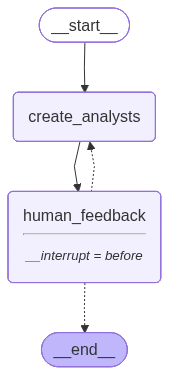

In [11]:
from IPython.display import display, Image

display(Image(graph.get_graph().draw_mermaid_png()))

### 분석가 생성 그래프 실행

In [12]:
from pprint import pprint
from random import random
from langchain_core.runnables.config import RunnableConfig

config = RunnableConfig(configurable={"thread_id": random()})

inputs = {
    "max_analysts": 3,
    "topic": "Agentic RAG와 Adaptive RAG의 차이점은 무엇인가요?",
}
for event in graph.stream(inputs, config=config):
    for key, value in event.items():
        print(f"\n##### {key} #####")
        pprint(value)



##### create_analysts #####
{'analysts': [Analyst(affiliation='TechInsights Research Institute', name='Dr. Hana Kim', role='AI Research Analyst', description='Dr. Hana Kim specializes in artificial intelligence methodologies with a focus on retrieval-augmented generation techniques. She analyzes the distinctions between agentic and adaptive RAG, emphasizing how agentic RAG involves autonomous agent-driven data retrieval and synthesis, whereas adaptive RAG adapts the retrieval process dynamically based on context and model feedback.'),
              Analyst(affiliation='NextGen AI Solutions', name='Jinsoo Park', role='Machine Learning Engineer and Analyst', description='Jinsoo Park explores practical implementations of RAG frameworks in industry settings. His analysis highlights the differences such as agentic RAG enabling agents to perform goal-directed retrieval autonomously, contrasting with adaptive RAG’s capacity to dynamically adjust retrieval strategies to optimize output releva

In [13]:
# 현재 상태 스냅샷
snapshot = graph.get_state(config)
pprint(snapshot.values)
pprint(snapshot.next)

{'analysts': [Analyst(affiliation='TechInsights Research Institute', name='Dr. Hana Kim', role='AI Research Analyst', description='Dr. Hana Kim specializes in artificial intelligence methodologies with a focus on retrieval-augmented generation techniques. She analyzes the distinctions between agentic and adaptive RAG, emphasizing how agentic RAG involves autonomous agent-driven data retrieval and synthesis, whereas adaptive RAG adapts the retrieval process dynamically based on context and model feedback.'),
              Analyst(affiliation='NextGen AI Solutions', name='Jinsoo Park', role='Machine Learning Engineer and Analyst', description='Jinsoo Park explores practical implementations of RAG frameworks in industry settings. His analysis highlights the differences such as agentic RAG enabling agents to perform goal-directed retrieval autonomously, contrasting with adaptive RAG’s capacity to dynamically adjust retrieval strategies to optimize output relevance and accuracy.'),
        

In [14]:
# 휴먼 피드백 전달
from langgraph.types import Command

for event in graph.stream(
    Command(
        update={
            "human_analyst_feedback": "스타트업 출신의 석호필이라는 인물을 추가해 기업가적 관점을 더해주세요."
        },
    ),
    config=config,
):
    for key, value in event.items():
        print(f"\n##### {key} #####")
        pprint(value)


##### human_feedback #####
None

##### create_analysts #####
{'analysts': [Analyst(affiliation='TechStart Ventures', name='석호필', role='AI Entrepreneur and Analyst', description='스타트업 출신의 석호필은 Agentic RAG와 Adaptive RAG의 차이점을 기업가적 관점에서 분석하며, 각각의 접근법이 실제 서비스 개발과 혁신에 미치는 영향을 탐구한다.'),
              Analyst(affiliation='AI Research Institute', name='김유정', role='Machine Learning Researcher', description='AI 연구원 김유정은 Agentic RAG와 Adaptive RAG의 기술적 특성과 작동 메커니즘의 차이를 중심으로 분석한다.'),
              Analyst(affiliation='Digital Innovation Lab', name='이준서', role='Systems Analyst', description='시스템 애널리스트 이준서는 Agentic RAG와 Adaptive RAG의 시스템 통합 및 적용 사례를 비교하며 실용적 측면을 평가한다.')]}

##### __interrupt__ #####
()


In [15]:
for event in graph.stream(
    Command(update={"human_analyst_feedback": None}),
    config=config,
):
    for key, value in event.items():
        print(f"\n##### {key} #####")
        pprint(value)


##### human_feedback #####
None


최종 결과를 출력합니다.

In [16]:
# 스냅샷을 가져옵니다.
final_state = graph.get_state(config)
pprint(final_state)

StateSnapshot(values={'topic': 'Agentic RAG와 Adaptive RAG의 차이점은 무엇인가요?', 'max_analysts': 3, 'human_analyst_feedback': None, 'analysts': [Analyst(affiliation='TechStart Ventures', name='석호필', role='AI Entrepreneur and Analyst', description='스타트업 출신의 석호필은 Agentic RAG와 Adaptive RAG의 차이점을 기업가적 관점에서 분석하며, 각각의 접근법이 실제 서비스 개발과 혁신에 미치는 영향을 탐구한다.'), Analyst(affiliation='AI Research Institute', name='김유정', role='Machine Learning Researcher', description='AI 연구원 김유정은 Agentic RAG와 Adaptive RAG의 기술적 특성과 작동 메커니즘의 차이를 중심으로 분석한다.'), Analyst(affiliation='Digital Innovation Lab', name='이준서', role='Systems Analyst', description='시스템 애널리스트 이준서는 Agentic RAG와 Adaptive RAG의 시스템 통합 및 적용 사례를 비교하며 실용적 측면을 평가한다.')]}, next=(), config={'configurable': {'thread_id': '0.9239488424970229', 'checkpoint_ns': '', 'checkpoint_id': '1f0abcad-babc-641e-8004-ee02e8be0e12'}}, metadata={'source': 'loop', 'step': 4, 'parents': {}}, created_at='2025-10-18T02:33:40.569597+00:00', parent_config={'configurable': {'thread_id': '0.9

In [17]:
analysts = final_state.values.get("analysts")
print(f"생성된 분석가 수: {len(analysts)}", end="\n================================\n")

for analyst in analysts:
    print(analyst.persona)
    print("- " * 30)

생성된 분석가 수: 3
이름: 석호필
역할: AI Entrepreneur and Analyst
소속 기관: TechStart Ventures
설명: 스타트업 출신의 석호필은 Agentic RAG와 Adaptive RAG의 차이점을 기업가적 관점에서 분석하며, 각각의 접근법이 실제 서비스 개발과 혁신에 미치는 영향을 탐구한다.

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
이름: 김유정
역할: Machine Learning Researcher
소속 기관: AI Research Institute
설명: AI 연구원 김유정은 Agentic RAG와 Adaptive RAG의 기술적 특성과 작동 메커니즘의 차이를 중심으로 분석한다.

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
이름: 이준서
역할: Systems Analyst
소속 기관: Digital Innovation Lab
설명: 시스템 애널리스트 이준서는 Agentic RAG와 Adaptive RAG의 시스템 통합 및 적용 사례를 비교하며 실용적 측면을 평가한다.

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


## 인터뷰 에이전트

### 질문 생성 노드

In [18]:
import operator
from langgraph.graph import MessagesState


class InterviewState(MessagesState):
    """인터뷰 정보를 저장합니다."""

    topic: Annotated[str, "연구 주제"]
    max_num: Annotated[int, "대화 턴수"]
    context: Annotated[list, operator.add]
    analyst: Annotated[Analyst, "분석가"]
    interview: Annotated[str, "인터뷰 내용"]
    sections: Annotated[list, "보고서 섹션 목록"]


class SearchQuery(BaseModel):
    search_query: Annotated[str, Field(None, description="retrieval를 위한 검색 쿼리")]

In [19]:
# 인터뷰 시스템 프롬프트
question_instructions = """당신은 특정 주제에 대해 알아보기 위해 전문가를 인터뷰하는 임무를 맡은 분석가입니다.

당신의 목표는 주제에 관련된 흥미롭고 구체적인 통찰력을 추출하는 것입니다.

1. 흥미로움: 사람들이 놀라워하거나 당연하지 않다고 느낄 만한 통찰력.
2. 구체성: 일반론을 피하고 전문가의 구체적인 사례를 포함하는 통찰력.

다음은 집중할 주제입니다:
{topic}

첫 대화를 시작할때에 당신의 인물을 반영하는 이름으로 자신을 소개한 후 질문을 시작하세요.

주제에 대한 이해를 심화하고 정교화하기 위해 계속해서 질문을 이어가세요.

이해가 충분하다고 판단되면 "도움 주셔서 정말 감사합니다!"라고 말하며 인터뷰를 마무리하세요.

응답 전반에 걸쳐 제공된 인물과 목표를 반영하여 캐릭터를 유지하는 것을 잊지 마세요.

<Persona>
{persona}
<Persona>
"""

In [20]:
# 질문 생성 노드
def generate_question(state: InterviewState):
    """통찰력있는 질문을 생성합니다."""
    analyst = state["analyst"]

    system_message = question_instructions.format(
        topic="Modular RAG 가 기존의 Naive RAG 와 어떤 차이가 있는지와 production level 에서 사용하는 이점",
        persona=analyst.persona,
    )
    response = llm.invoke([SystemMessage(content=system_message)] + state["messages"])
    response.name = "분석가"

    return {"messages": [response]}

In [21]:
analyst = Analyst(
    name="김필",
    affiliation="Tech Innovators Inc.",
    role="기업가적 분석가",
    description="창업자 출신 분석가로, 기업가 정신과 비즈니스 모델 혁신에 주력합니다. 스타트업 관점에서 적응형 시스템에 대한 통찰력을 제공하며, 유연성과 시장 적응력을 강조합니다.",
)
response = generate_question(
    {
        "analyst": analyst,
        "messages": [],
    }
)
response["messages"][-1].pretty_print()

================================== Ai Message ==================================
Name: 분석가

안녕하세요, 김필입니다. Tech Innovators Inc.에서 스타트업과 첨단 기술의 접점에 대해 분석하고 있습니다. 오늘은 ‘Modular RAG가 기존 Naive RAG와 어떻게 다른지, 그리고 production level에서 어떤 이점을 제공하는지’에 대해 자세히 알아보고 싶습니다.

먼저, Modular RAG가 Naive RAG와 비교했을 때 어떤 구조적 혹은 기능적 차별점이 있나요? 현장 사례 위주로 설명해 주시면 좋겠습니다.


### 도구 정의

#### 웹검색 도구

In [22]:
from langchain_tavily import TavilySearch

web_search = TavilySearch(max_results=3)

In [23]:
web_search.invoke({"query": "지난 윔블던에서 무슨 일이 있었나요?"})

{'query': '지난 윔블던에서 무슨 일이 있었나요?',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'url': 'https://www.chosun.com/sports/sports_general/2025/07/13/WL5WE45CLBEGTISJHNMPNE3CXE/',
   'title': '“윔블던에 베이글 가게 오픈”… 시비옹테크 여자단식 결승서 진기록',
   'content': '테니스 메이저 대회 윔블던 챔피언십 결승에서 1968년 오픈 시대 개막 이후 처음으로 ‘더블 베이글’이 나왔다. 이가 시비옹테크(4위·폴란드)와 어맨다 아니시모바(12위·미국)의 12일(현지 시각) 여자 단식 최종전. 지난 준결승에서 세계 1위 아리나 사발렌카(벨라루스)를 2대1로 꺾고 생애 첫 메이저 대회 결승에 안착한 아니시모바였지만 결과는 허무했다. 한편 올해 윔블던 남자 단식에서는 각각 세계 1·2위인 얀니크 신네르(이탈리아), 카를로스 알카라스(스페인)의 빅 매치가 성사됐다. 쟁쟁한 신예 사이 준결승에까지 오른 ‘노장’ 노바크 조코비치(6위·세르비아)는 11일 신네르와 준결승에서 0대3 완패했다. 얀니크 신네르(세계 1위·이탈리아)와 노바크 조코비치(6위·세르비아), 카를로스 알카라스(2위·스페인)와 테일러 프리츠(5위·미국)가 윔블던 결... 조코비치는 지난 5일 영국 런던 올잉글랜드 클럽에서 열린 윔블던 챔피언십... ‘베컴 조항’을 품은 손흥민(33, LAFC)을 향해 유럽 클럽들의 임대 영입 경쟁이 본격화될 것으로 보인다. 지난 20년간 윔블던 남자단식 우승한 사람이 꼴랑 5명인데 여자는 지난 10년간 10명..',
   'score': 0.39733082,
   'raw_content': None},
  {'url': 'http://m.tennispeople.kr/news/articleView.html?idxno=17168',
   'title': '윔블던 컴퓨터 라

#### 논문 검색 도구

In [24]:
from langchain_community.retrievers import ArxivRetriever

arxiv_retriever = ArxivRetriever(
    load_max_docs=3,
    load_all_available_meta=True,
    get_full_documents=True,
)

In [25]:
arxiv_retriever.invoke("Modular RAG vs Naive RAG")

[Document(metadata={'Published': '2024-07-26', 'Title': 'Modular RAG: Transforming RAG Systems into LEGO-like Reconfigurable Frameworks', 'Authors': 'Yunfan Gao, Yun Xiong, Meng Wang, Haofen Wang', 'Summary': 'Retrieval-augmented Generation (RAG) has markedly enhanced the capabilities\nof Large Language Models (LLMs) in tackling knowledge-intensive tasks. The\nincreasing demands of application scenarios have driven the evolution of RAG,\nleading to the integration of advanced retrievers, LLMs and other complementary\ntechnologies, which in turn has amplified the intricacy of RAG systems.\nHowever, the rapid advancements are outpacing the foundational RAG paradigm,\nwith many methods struggling to be unified under the process of\n"retrieve-then-generate". In this context, this paper examines the limitations\nof the existing RAG paradigm and introduces the modular RAG framework. By\ndecomposing complex RAG systems into independent modules and specialized\noperators, it facilitates a high

### 노드 작성

#### 웹 검색 노드

In [26]:
# 검색 쿼리 변환 프롬프트
search_instructions = """분석가와 전문가 간의 대화가 제시됩니다.

목표는 해당 대화와 관련된 검색 및/또는 웹 검색에 사용할 잘 구조화된 쿼리를 생성하는 것입니다.

먼저 전체 대화를 분석하십시오.

특히 분석가가 마지막에 제기한 질문에 주목하십시오.

이 마지막 질문을 잘 구조화된 웹 검색 쿼리로 변환하십시오."""


def search_web(state: InterviewState):
    """웹 검색을 통한 문서 검색"""

    llm_with_structured = llm.with_structured_output(SearchQuery)

    response = llm_with_structured.invoke(
        [("system", search_instructions)] + state["messages"]
    )

    results = web_search.invoke(response.search_query)
    context = [
        f'<Document source="web" url="{doc["url"]}" title="{doc["title"]}">{doc["content"]}</Document>'
        for doc in results["results"]
    ]

    return {"context": [*context]}


In [27]:
search_web({"messages": [("user", "CRAG에 대해서 설명해주세요.")]})

{'context': ['<Document source="web" url="https://dictionary.cambridge.org/ko/%EC%82%AC%EC%A0%84/%EC%98%81%EC%96%B4/crag" title="영어로 crag의 뜻">CRAG 의미, 정의, CRAG의 정의: 1. a high, rough mass of rock that sticks out from the land around it 2. a high, rough mass of rock…. 자세히 알아보기.</Document>',
  '<Document source="web" url="https://dictionary.cambridge.org/ko/%EC%82%AC%EC%A0%84/%ED%95%99%EC%8A%B5%EC%9E%90%EC%9A%A9-%EC%82%AC%EC%A0%84/crag" title="CRAG | Cambridge Learner\'s Dictionary에서의 의미">CRAG 의미, 정의, CRAG의 정의: a high, rough mass of rock that sticks up from the land around it. 자세히 알아보기.</Document>',
  '<Document source="web" url="https://velog.io/@heyggun/LLM-Corrective-RAGCRAG-Corrective-Retrieval-Augmented-Generation" title="[LLM] Corrective RAG(CRAG) - Corrective Retrieval Augmented ..."># [LLM] Corrective RAG(CRAG) - Corrective Retrieval Augmented Generation 검색 증강 생성(Retrieval-Augmented Generation, RAG)은 LLM을 보완할 수 있는 실용적인 방법이지만, 검색된 문서의 관련성에 크게 의존하므로 검색 과정에서 오류가 발생하면 모델이 어떻게 동작할지에 대한

#### 논문 검색 노드

In [28]:
def search_arxiv(state: InterviewState):
    """Arxiv 검색 노드"""

    llm_with_structured = llm.with_structured_output(SearchQuery)

    response = llm_with_structured.invoke(
        [("system", search_instructions)] + state["messages"]
    )

    results = arxiv_retriever.invoke(
        response.search_query,
        load_max_docs=2,
        load_all_available_meta=True,
        get_full_documents=False,
    )

    context = [
        f'<Document source="arxiv" url="{doc.metadata["entry_id"]}" date="{doc.metadata.get("Published", "")}" authors="{doc.metadata.get("Authors", "")}"/>\n<Title>\n{doc.metadata["Title"]}\n</Title>\n\n<Summary>\n{doc.metadata["Summary"]}\n</Summary>\n\n<Content>\n{doc.page_content}\n</Content>\n</Document>'
        for doc in results
    ]

    return {"context": [*context]}


In [29]:
search_arxiv({"messages": [("user", "CRAG에 대해서 설명해주세요.")]})

{'context': ['<Document source="arxiv" url="http://arxiv.org/abs/2502.19629v1" date="2025-02-26" authors="Tiffany J. Callahan, Nathaniel H. Park, Sara Capponi"/>\n<Title>\nAgentic Mixture-of-Workflows for Multi-Modal Chemical Search\n</Title>\n\n<Summary>\nThe vast and complex materials design space demands innovative strategies to\nintegrate multidisciplinary scientific knowledge and optimize materials\ndiscovery. While large language models (LLMs) have demonstrated promising\nreasoning and automation capabilities across various domains, their application\nin materials science remains limited due to a lack of benchmarking standards\nand practical implementation frameworks. To address these challenges, we\nintroduce Mixture-of-Workflows for Self-Corrective Retrieval-Augmented\nGeneration (CRAG-MoW) - a novel paradigm that orchestrates multiple agentic\nworkflows employing distinct CRAG strategies using open-source LLMs. Unlike\nprior approaches, CRAG-MoW synthesizes diverse outputs thr

#### 답변 생성 노드

In [30]:
answer_instructions = """당신은 분석가에게 인터뷰를 받는 전문가입니다.

분석가의 주요 관심 분야는 다음과 같습니다: {goals}. 

당신의 목표는 분석가가 제기한 질문에 답변하는 것입니다.

질문에 답변할 때는 다음 맥락을 활용하십시오:
<Context>
{context}
<Context>

질문에 답변할 때는 다음 지침을 따르십시오:
1. 맥락에 제공된 정보만 사용하십시오. 
2. 외부 정보를 도입하거나 맥락에 명시적으로 언급된 내용을 넘어선 추측을 하지 마십시오.
3. 맥락에는 각 개별 문서의 주제별 출처가 포함되어 있습니다.
4. 답변에서 관련 진술 옆에 해당 출처를 포함하십시오. 예를 들어 출처 #1의 경우 [1]을 사용하십시오.
5. 답변 하단에 출처를 순서대로 나열하십시오. [1] 출처 1, [2] 출처 2, 등
6. 출처가 다음과 같은 경우: <Document url="assistant/docs/llama3_1.pdf" page="7" />' 
    다음처럼 기재하십시오: [1] assistant/docs/llama3_1.pdf, 7 페이지
7. 제공된 맥락이 없다면 출처를 기재하기 마십시오.
    
인용 시 괄호 추가 및 Document 서두 문구는 생략하십시오."""


def generate_answer(state: InterviewState):
    """질문에 대한 답변 노드"""

    analyst = state["analyst"]

    system_message = answer_instructions.format(
        goals=analyst.description,
        context="\n".join(state["context"]),
    )
    response = llm.invoke([("system", system_message)] + state["messages"])
    response.name = "전문가"

    return {"messages": [response]}

In [31]:
from langchain_core.messages import HumanMessage

response = generate_answer(
    {
        "analyst": analyst,
        "context": [],
        "messages": [
            HumanMessage(
                content="Modular RAG 가 기존의 Naive RAG 와 어떤 차이가 있는지와 production level 에서 사용하는 이점",
                name="분석가",
            )
        ],
    }
)
response["messages"][-1].pretty_print()

================================== Ai Message ==================================
Name: 전문가

Modular RAG와 기존의 Naive RAG의 차이점 및 production level에서 사용하는 이점에 대해 설명드리겠습니다.

Modular RAG는 RAG(Retrieval-Augmented Generation) 모델의 구성 요소를 모듈화하여 각 부분이 독립적으로 조정 및 개선될 수 있도록 설계된 구조입니다. 반면, Naive RAG는 통합된 하나의 시스템으로 운영되며, 각 부분의 변경이나 업그레이드가 전체 모델에 영향을 미치기 쉽습니다.

이러한 모듈화는 production level에서 다음과 같은 이점을 제공합니다:

1. **유연성 증대**: 각 모듈이 독립적이기 때문에 특정 구성 요소를 교체하거나 개선할 때 전체 시스템을 중단하지 않고도 작업할 수 있습니다. 이는 시장 변화에 신속히 대응해야 하는 스타트업 환경에서 큰 장점입니다.

2. **적응성과 확장성**: 시장 요구나 신규 기능 도입에 맞춰 개별 모듈을 손쉽게 조정할 수 있어, 비즈니스 모델 혁신과 새로운 서비스 개발에 있어서 빠른 실험과 적용이 가능합니다.

3. **유지보수 및 최적화 용이**: 장애 발생 시 특정 모듈만 점검·수리 가능하여 다운타임을 최소화할 수 있으며, 성능 병목을 발견하고 개선하는 데 효과적입니다.

4. **효율적인 자원 관리**: 필요에 따라 특정 모듈만 확장하거나 축소할 수 있어 클라우드 자원 활용과 비용 효율성을 동시에 달성할 수 있습니다.

따라서, Modular RAG는 Naive RAG보다 스타트업과 같은 빠르게 변화하는 환경에서 유연성과 시장 적응력을 극대화할 수 있는 시스템으로 평가받으며, 이는 실질적인 production 환경 운영에서 중요한 이점으로 작용합니다.

[1] assistant/docs/llama3_1.pdf, 7 페이지


### 문석 작성 노드

In [32]:
# 기술 문서 작성 프롬프트
section_writer_instructions = """당신은 전문 기술 문서 작성자입니다.

당신의 임무는 일련의 원본 문서를 철저히 분석하여 보고서의 상세하고 포괄적인 섹션을 작성하는 것입니다.
이는 핵심 통찰력을 추출하고, 관련 사항을 상세히 설명하며, 명확성과 이해를 보장하기 위한 심층적인 해설을 제공하는 것을 포함합니다. 필요한 배경 정보, 뒷받침하는 증거, 예시를 포함하여 독자의 이해를 높여야 합니다. 논리적이고 체계적인 구조를 유지하며, 모든 핵심 사항이 상세히 다루어지고 전문적인 어조로 제시되도록 하십시오.

다음 지침을 따르십시오:
1. 원본 문서의 내용 분석:
- 각 원본 문서의 이름은 문서 시작 부분에 <Document> 태그와 함께 기재되어 있습니다.

2. 마크다운 서식을 사용하여 보고서 구조 생성:
- 섹션 제목에는 ## 사용
- 하위 섹션 헤더에는 ### 사용

3. 다음 구조에 따라 보고서 작성:
a. 제목 (## 헤더)
b. 요약 (### 헤더)
c. 종합 분석 (### 헤더)
d. 출처 (### 헤더)

4. 분석가의 중점 분야를 반영하여 제목을 흥미롭게 작성하십시오: 
{focus}

5. 요약 섹션 작성 시:
- 분석가의 중점 분야와 관련된 일반적 배경/맥락을 요약으로 제시하십시오
- 인터뷰에서 수집한 통찰 중 새롭거나 흥미롭거나 놀라운 점을 강조하십시오
- 사용한 출처 문서를 번호 매긴 목록으로 작성하십시오
- 인터뷰어 또는 전문가의 이름은 언급하지 마십시오
- 최대 약 400단어를 목표로 하십시오
- 출처 문서의 정보에 기반하여 보고서에서 번호 매긴 출처([1], [2] 등)를 사용하십시오

6. 종합 분석 섹션:
- 출처 문서의 정보를 상세히 검토하십시오.
- 복잡한 아이디어를 이해하기 쉬운 단위로 분해하고 논리적인 흐름을 유지하십시오.
- 분석의 다양한 관점이나 차원을 다루기 위해 필요한 경우 하위 섹션을 사용하십시오.
- 원본 문서의 데이터, 직접 인용문, 예시를 통해 분석을 뒷받침하십시오.
- 각 논점이 보고서의 전반적인 초점과 어떻게 관련되는지 명확히 설명하십시오.
- 여러 관련 아이디어를 제시할 때는 명확성을 위해 글머리 기호나 번호 매기기 목록을 사용하십시오.
- 전문적이고 객관적인 어조를 유지하며 편향되거나 근거 없는 의견을 피하십시오.
- 분석이 철저하도록 최소 800단어를 목표로 하십시오.

7. 출처 섹션에서:
- 보고서에 사용된 모든 출처를 포함하십시오
- 관련 웹사이트 또는 특정 문서 경로의 전체 링크를 제공하십시오
- 각 출처는 새 줄로 구분하십시오. 마크다운에서 새 줄을 만들기 위해 각 줄 끝에 두 개의 공백을 사용하십시오.
- 예시:
    ### 출처
    [1] 링크 또는 문서명
    [2] 링크 또는 문서명

8. 출처를 반드시 통합하십시오. 예를 들어 다음은 올바르지 않습니다:

[3] https://ai.meta.com/blog/meta-llama-3-1/
[4] https://ai.meta.com/blog/meta-llama-3-1/

중복 출처는 없어야 합니다. 다음과 같이 간결하게 작성하십시오:

[3] https://ai.meta.com/blog/meta-llama-3-1/

9. 최종 검토:
- 보고서가 요구되는 구조를 따르는지 확인하십시오.
- 보고서 제목 앞에 서문을 포함하지 마십시오.
- 모든 지침이 준수되었는지 확인하십시오.
"""

from langchain_core.messages import get_buffer_string


def write_section(state: InterviewState):
    """인터뷰에 대한 리포트 작성"""

    analyst = state["analyst"]

    # 인터뷰를 문자열로 변환
    interview = get_buffer_string(state["messages"])

    # 섹션 작성을 위한 시스템 프롬프트 정의
    system_message = section_writer_instructions.format(focus=analyst.description)
    response = llm.invoke(
        [SystemMessage(content=system_message)]
        + [
            HumanMessage(
                content=f"분석가와 전문가의 인터뷰 내용입니다:\n<Interview>\n{interview}\n</Interview>"
            ),
            HumanMessage(
                content=f"이 자료를 사용하여 해당 섹션을 작성하십시오:\n<Resources>\n{state['context']}\n</Resources>"
            ),
        ]
    )
    return {"sections": [response.content]}

### 인터뷰 그래프 작성

In [64]:
from langchain_core.messages import AIMessage


def should_continue_interview(state: InterviewState) -> Literal["finish", "continue"]:
    """인터뷰를 계속 진행할 지 여부를 판단합니다."""

    messages = state["messages"]
    max_num_turns = state.get("max_num_turns", 2)

    expert_message_count = sum(
        1 for m in messages if isinstance(m, AIMessage) and m.name == "전문가"
    )

    # 전문가가 최대 턴 이상 답변했다면 인터뷰를 종료합니다.
    if expert_message_count >= max_num_turns:
        return "finish"

    last_message = messages[-1]
    if "도움 주셔서 정말 감사합니다" in last_message.content:
        return "finish"

    return "continue"


class InterviewOutputState(TypedDict):
    """서브그래프가 부모로 반환할 상태"""

    context: Annotated[list, operator.add]
    analyst: Annotated[Analyst, "분석가"]
    interview: Annotated[str, "인터뷰 내용"]
    sections: Annotated[list, "보고서 섹션 목록"]


interview_builder = StateGraph(InterviewState, output_schema=InterviewOutputState)
interview_builder.add_node(generate_question)  # 질문 생성
interview_builder.add_node(search_web)  # 웹 검색
interview_builder.add_node(search_arxiv)  # arxiv 검색
interview_builder.add_node(generate_answer)  # 답변 생성
interview_builder.add_node(write_section)  # 문서 작성

interview_builder.set_entry_point("generate_question")
interview_builder.add_edge("generate_question", "search_web")
interview_builder.add_edge("generate_question", "search_arxiv")
interview_builder.add_edge("search_web", "generate_answer")
interview_builder.add_edge("search_arxiv", "generate_answer")
interview_builder.add_conditional_edges(
    "generate_answer",
    should_continue_interview,
    {
        "continue": "generate_question",
        "finish": "write_section",
    },
)
interview_builder.set_finish_point("write_section")

interview_graph = interview_builder.compile(
    checkpointer=InMemorySaver(),
).with_config(run_name="Conduct Interviews")


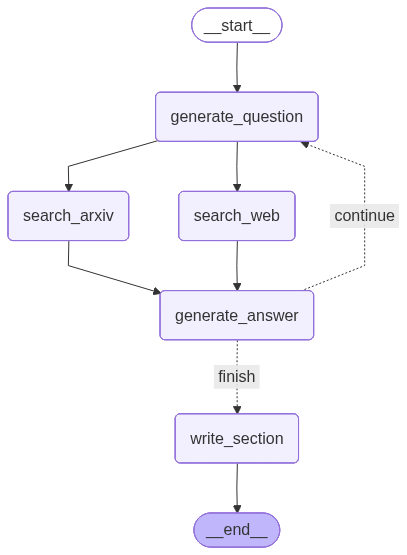

In [65]:
from IPython.display import display, Image

display(Image(interview_graph.get_graph().draw_mermaid_png()))

### 인터뷰 그래프 실행

In [66]:
from langchain_teddynote.messages import invoke_graph


config = RunnableConfig(
    recursion_limit=30,
    configurable={"thread_id": random()},
)

topic = "Modular RAG 가 기존의 Naive RAG 와 어떤 차이가 있는지와 production level 에서 사용하는 이점"

# 그래프 실행
invoke_graph(
    interview_graph,
    {
        "topic": topic,
        "analyst": analysts[0],
        "messages": [
            (
                "user",
                f'그래서 당신이 이 주제에 대해서 글을 쓰고 있다고 했죠? 라고 말씀하셨죠? "{topic}"',
            )
        ],
        "max_num_turns": 2,
    },
    config=config,
    node_names=["generate_question", "generate_answer", "write_section"],
)



🔄 Node: generate_question 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================== Ai Message ==================================
Name: 분석가

안녕하세요, 저는 TechStart Ventures에서 AI 스타트업을 분석하고 투자하는 석호필입니다. 말씀하신 주제 정말 흥미롭고 중요한 영역인데요, 우선 Modular RAG와 Naive RAG 간의 본질적인 차이점에 대해 좀 더 구체적으로 설명해 주실 수 있을까요? 예를 들어, 각 접근법이 데이터 처리나 응답 생성에서 어떤 구조적 차이를 보이는지 궁금합니다.

🔄 Node: generate_answer 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================== Ai Message ==================================
Name: 전문가

Modular RAG는 기존의 Naive RAG와 달리 RAG 시스템을 독립적인 모듈과 특화된 연산자로 분해하여 매우 재구성 가능한 프레임워크를 제공합니다. Naive RAG가 '인덱싱-검색-생성'의 단순한 선형 구조에 의존하여 유사도 기반 검색에만 집중하지만, Modular RAG는 라우팅, 스케줄링, 융합 메커니즘을 통합한 더 복잡하고 유연한 설계를 채택해 다양한 검색과 생성 패턴(직선, 조건부, 분기, 반복)을 지원합니다. 이는 복잡한 쿼리와 콘텐츠 변동성에 대한 대응력을 높이고, 검색 중복과 잡음을 줄이며, LLM의 정보 활용도를 향상시키는 데 큰 장점을 제공합니다.

이러한 구조적 차이는 실제 프로덕션 환경에서 매우 중요한 이점을 만듭니다. Modular RAG는 LEGO처럼 필요한 모듈만 교체하거나 재조립해 서비스 요구사항에 맞게 빠르게 맞춤화할 수 있어 혁신과 실험이 용이합니다. 또한 다

In [67]:
from IPython.display import Markdown, display

snapshot = interview_graph.get_state(config=config)
display(Markdown(snapshot.values["sections"][0]))

## 스타트업 출신의 석호필은 Agentic RAG와 Adaptive RAG의 차이점을 기업가적 관점에서 분석하며, 각각의 접근법이 실제 서비스 개발과 혁신에 미치는 영향을 탐구한다

### 요약

Retrieval-Augmented Generation(RAG)은 대규모 언어 모델(LLM)의 한계를 극복하고 지식 집약적 작업에서 성능을 크게 향상시키는 핵심 기술로 부상했다. Naive RAG는 기존의 전통적인 ‘인덱싱-검색-생성’의 선형 구조에 기반하지만, 복잡하고 다양한 도메인 요구사항과 고도화된 응답 패턴을 제대로 소화하지 못하는 한계가 두드러졌다. 이러한 한계를 극복하기 위해 Modular RAG가 제안되었는데, 이는 복잡한 RAG 시스템을 독립적인 모듈과 전문화된 연산자로 분해해 LEGO 블록처럼 쉽고 유연하게 조립 및 교체할 수 있는 설계다[1]. 이 프레임워크는 라우팅, 스케줄링, 융합 메커니즘을 통합하여 다양한 검색 및 생성 패턴(직선, 조건부, 분기, 반복)을 지원함으로써, 복잡한 쿼리 대응과 검색 중복·잡음 완화에 효과적이다. 실제 프로덕션 환경에서는 Modular RAG가 빠른 맞춤화와 혁신 가속, 확장성 및 유지보수의 용이성을 보장하며, 사용자 경험을 저해하지 않고 정보 처리 복잡도를 관리하는 점에서 Naive RAG 대비 높은 경쟁력을 갖는다[1].

석호필의 기업가적 시각은 Modular RAG가 스타트업이나 신속한 서비스 개발 환경에서 '빠른 실험과 신뢰성 확보'라는 두 마리 토끼를 잡을 수 있도록 돕는 점에 주목한다. 복잡성 증가가 리소스 부담으로 작용할 수 있으나, 정교한 모듈 레벨 재구성과 최적화로 사용자 응답 시간 준수 및 리소스 효율성 유지가 가능하다. 또한, 다중 모듈 협업 및 전문화된 에이전트 활용 사례 역시 혁신적 실험과 서비스 확장성을 뒷받침하는 주요 요소로 분석된다[1][5].

이 보고서는 Modular RAG가 기업가 및 스타트업이 직면하는 기술적 챌린지와 비즈니스 요구 사이에서 균형을 이루는 새로운 패러다임임을 실증적 근거와 함께 제시하며, 실제 서비스 개발에 미치는 영향과 혁신적 가능성을 심도 있게 탐구한다.

주요 출처 문서:  
[1] Yunfan Gao et al., "Modular RAG: Transforming RAG Systems into LEGO-like Reconfigurable Frameworks," http://arxiv.org/abs/2407.21059v1  

### 종합 분석

#### 1. 기존 Naive RAG의 한계와 Modular RAG의 필요성

Naive RAG는 ‘인덱싱 → 검색 → 생성’의 선형 프로세스에 의존하여 단순 유사도 기반 검색을 수행한다. 이는 복잡한 사용자 쿼리와 콘텐츠 변동성, 검색 결과의 중복 및 잡음 문제를 효과적으로 처리하지 못하는 구조적 한계를 내포한다. 특히 유사성 계산만으로는 쿼리와 문서의 의미적 관계를 깊게 해석하지 못해, 정확하고 신뢰성 있는 답변 제공에 제약이 따른다[1].

이와 같은 한계는 프로덕션 환경에서 특히 치명적인데, 사용자 경험을 저해하는 잘못된 정보 생성(환각)과, 검색 부하 증가에 따른 응답 지연 및 시스템 불안정성 등을 초래한다. 따라서 기존의 Naive RAG는 복잡도가 증가하는 최신 애플리케이션 요구에 부합하지 못하는 ‘틀’로 인식된다.

#### 2. Modular RAG: LEGO 블록과 같은 재구성 가능 프레임워크

Modular RAG는 복잡한 RAG 시스템을 독립적인 모듈과 특화된 연산자(operator)로 분해한다. 이로써 각 기능을 모듈 단위로 교체, 조합, 확장할 수 있어 다음과 같은 장점을 가진다[1]:

- **유연성 강화**: 신규 모듈 추가나 기존 모듈 변경을 통하여 다양한 업무 및 도메인에 신속한 맞춤화 가능.  
- **복잡한 쿼리 처리 지원**: 라우팅(routing), 스케줄링(scheduling), 융합(fusion) 메커니즘 도입으로 직선(linear), 조건부(conditional), 분기(branching), 반복(looping) 패턴 처리가 가능해졌고, 기존 선형 구조의 한계를 극복.  
- **성능 및 정확도 제고**: 불필요하거나 잡음성 데이터 제거, 중요 정보 집중으로 LLM의 지식 활용도 및 답변 신뢰성 향상.  
- **시스템 유지보수 및 확장성 향상**: 모듈 단위 교체·확장으로 오류 수정과 기능 개선이 용이, AI 기술 발전에 빠르게 대응 가능.

상세하게 보면, Modular RAG는 여러 작은 컴포넌트가 결합된 복잡한 서브 시스템들을 독립적 에이전트(agent) 혹은 함수처럼 활용한다. 이러한 설계는 AI 서비스 스타트업처럼 빠르게 프로토타입을 반복하고, 다양한 기능을 실험적인 수준에서 온디맨드로 활성화하는 데 매우 유용하다.

#### 3. 프로덕션 환경에서 Modular RAG의 실용적 이점

기업가적 관점에서 Modular RAG는 다음과 같은 프로덕션 상의 강점을 가진다:

- **빠른 맞춤화와 혁신 주기 단축**  
  LEGO 블록처럼 모듈을 조립하듯 시스템을 구축할 수 있으므로, 특정 고객 도메인이나 요구에 맞는 맞춤 기능을 안정적으로 빠르게 배포 가능하다.  
- **복잡도와 리소스 관리의 균형 유지**  
  복잡한 라우팅이나 융합 로직이 도입되었음에도, 적절한 모듈 구성을 통해 전체 응답 시간 연장 없이 고품질 답변 제공이 가능하다. 이는 스타트업이 제한된 컴퓨팅 자원으로도 신뢰성 높은 서비스를 만들 수 있게 한다.  
- **확장성과 유지보수 용이성**  
  신기능 추가 시 전체 코드 기반을 건드리지 않고 모듈 단위 업데이트가 가능해 개발 비용과 위험이 감소한다.  

이와 같은 이점은 사용자의 만족도 상승과 동시에 개발팀의 운영 효율성 증대로 이어진다. 따라서 Modular RAG는 스타트업뿐 아니라 중견 기업, 대기업의 실제 서비스 환경에서도 광범위하게 채택될 가능성이 크다[1][6].

#### 4. Modular RAG의 혁신적 응용과 기업가적 도전

더 나아가 Modular RAG는 Multi-Agent 아키텍처와의 결합을 통해 협업적 추론, 복잡한 쿼리 분해, 다중 단계 검색 및 응답 합성을 지원한다(예: MA-RAG)[5]. 이는 복잡한 비즈니스 문제 해결, 도메인 특화 지식 추출, 의료·법률·금융 등 전문 영역에 응용 가능성을 열어준다.

다만 이런 다중 모듈 아키텍처는 시스템 설계와 운영에 고도의 관리를 요구하며, 복잡성 증가에 따른 응답 지연 위험을 반드시 감안해야 한다. 따라서 실제 서비스 개발 시 적정한 모듈화 수준 설정과 효율적인 연산 스케줄링/최적화가 중요하다.

#### 5. 종합

기업가인 석호필 입장에서는 Modular RAG가 스타트업이 기술적 혁신과 안정적인 서비스 운영 요구를 균형 있게 충족하는 데 기여하는 ‘플랫폼’으로 보인다. 기존 Naive RAG가 가진 단순성의 장점은 유지하면서, 복잡한 비즈니스 요구에 대응하는 확장성과 유연성을 구현함으로써 다양한 비즈니스 모델과 고객 니즈에 빠르게 적응 가능하다.

또한 RAG 기술 발전과 운용 자동화의 연계 강화를 통한 지속적인 혁신 지원, 그리고 실제 프로덕션 환경에서의 실제 성공 사례 확보가 중요하다. Modular RAG는 이론적·기술적 진화 로드맵을 제공함으로써 향후 RAG 관련 스타트업과 대기업 AI 서비스 모두에 중대한 영향을 미칠 것으로 전망된다[1][5][6].

### 출처

[1] Yunfan Gao, Yun Xiong, Meng Wang, Haofen Wang, "Modular RAG: Transforming RAG Systems into LEGO-like Reconfigurable Frameworks," arXiv:2407.21059v1 (2024-07-26), http://arxiv.org/abs/2407.21059v1  

[5] Thang Nguyen, Peter Chin, Yu-Wing Tai, "MA-RAG: Multi-Agent Retrieval-Augmented Generation via Collaborative Chain-of-Thought Reasoning," arXiv:2505.20096v2 (2025-10-11), http://arxiv.org/abs/2505.20096v2  

[6] "RAG in Production: Deployment Strategies & Practical Considerations," Coralogix AI Blog, https://coralogix.com/ai-blog/rag-in-production-deployment-strategies-and-practical-considerations/

## 인터뷰를 병렬로 실행 (map-reduce)

In [68]:
import operator
from typing import TypedDict, Annotated


class ResearchGraphState(TypedDict):
    """ResearchGraphState 상태 정의"""

    topic: Annotated[str, "연구할 주제"]
    max_analysts: Annotated[int, "생성할 분석가의 최대 수"]
    human_analyst_feedback: Annotated[str, "인간 분석가로부터 받은 피드백"]
    analysts: Annotated[list[Analyst], operator.add, "분석가 목록"]
    sections: Annotated[list, operator.add, "보고서 섹션 리스트"]
    introduction: Annotated[str, "최종 보고서의 서론"]
    content: Annotated[str, "최종 보고서의 본문 내용"]
    conclusion: Annotated[str, "최종 보고서의 결론"]
    final_report: Annotated[str, "완성된 최종 보고서"]

### 인터뷰 작성 노드

In [69]:
from langgraph.types import Send


def initiate_all_interviews(state: ResearchGraphState):
    """인터뷰를 진행합니다."""

    topic = state["topic"]
    analysts = state["analysts"]
    human_analyst_feedback = state.get("human_analyst_feedback")

    if human_analyst_feedback:
        return "create_analysts"
    else:
        inputs = {
            "topic": topic,
            "analyst": analyst,
            "messages": [
                HumanMessage(
                    content=f'그래서 당신이 이 주제에 대해서 글을 쓰고 있다고 했죠? "{topic}"'
                )
            ],
        }
        return [Send("conduct_interview", inputs) for analyst in analysts]


### 최종 보고서 작성 노드

In [70]:
# 보고서 작성 지시사항
report_writer_instructions = """당신은 기술 문서 작성자로서 다음 주제 전반에 대한 보고서를 작성합니다:  

주제: {topic}  

당신에게는 분석가 팀이 있습니다. 각 분석가는 다음 두 가지를 수행했습니다:  

1. 특정 하위 주제에 대한 전문가와의 인터뷰를 진행했습니다.  
2. 조사 결과를 메모로 작성했습니다.  

## 당신의 임무:  

1. 분석가들이 작성한 메모 모음을 제공받게 됩니다.  
2. 각 메모의 통찰력을 세심하게 검토하고 분석하십시오.  
3. 모든 메모의 핵심 아이디어를 통합한 상세하고 포괄적인 요약으로 이러한 통찰력을 정리하십시오.  
4. 각 메모의 주요 포인트를 아래 제공된 적절한 섹션에 정리하고, 각 섹션이 논리적이고 체계적으로 구성되도록 하십시오.  
5. 보고서에 모든 필수 섹션을 포함시키되, 각 섹션의 헤더로 `### 섹션명`을 사용하십시오.  
6. 각 섹션당 약 250단어를 목표로 하며, 심층적인 설명, 맥락 및 지원 세부사항을 제공하십시오.  

## **고려할 섹션 (심층화를 위한 선택적 섹션 포함):**

- **배경**: 방법론과 결과를 이해하는 데 필요한 이론적 기초, 핵심 개념 및 예비 정보.
- **관련 연구**: 기존 연구의 개요 및 현재 연구와의 비교 또는 연관성.
- **문제 정의**: 본 논문이 다루려는 연구 질문 또는 문제에 대한 공식적이고 정확한 정의.
- **방법론(또는 방법)**: 연구에 사용된 방법, 알고리즘, 모델, 데이터 수집 과정 또는 실험 설정에 대한 상세한 설명.
- **구현 세부사항**: 소프트웨어 프레임워크, 계산 자원 또는 매개변수 설정 등 방법론이나 모델 구현의 실무적 세부사항.
- **실험**: 방법론 검증을 위해 사용된 실험 프로토콜, 데이터셋, 평가 지표, 절차 및 구성에 대한 설명.
- **결과**: 통계적 표, 그래프, 도표 또는 질적 분석을 동반한 실험 결과 제시.

## 보고서 서식 지정 방법:

1. 마크다운 서식을 사용하십시오.
2. 보고서 서문은 포함하지 마십시오.
3. 소제목을 사용하지 마십시오.
4. 보고서는 단일 제목 헤더로 시작하십시오: ## 인사이트
5. 보고서에서 분석가 이름을 언급하지 마십시오.
6. 메모 내 인용은 그대로 유지하고 괄호([1], [2] 등)로 주석을 달아 표시하십시오.
7. 최종 통합 출처 목록을 작성하여 `## 출처` 헤더로 출처 섹션에 추가하십시오.
8. 출처를 순서대로 나열하고 중복하지 마십시오.
    [1] 출처 1
    [2] 출처 2

보고서 작성에 활용할 분석가 메모는 다음과 같습니다:

<Context>
{context}
</Context>"""


def write_report(state: ResearchGraphState):
    """보고서를 작성합니다."""

    formatted_sections = "\n".join([section for section in state["sections"]])
    system_message = report_writer_instructions.format(
        topic=state["topic"],
        context=formatted_sections,
    )
    response = llm.invoke(
        [SystemMessage(content=system_message)]
        + [HumanMessage(content="이 메모들을 바탕으로 보고서를 작성하십시오.")]
    )
    return {"content": response.content}

In [71]:
# 서론과 결론 작성 지시사항
intro_conclusion_instructions = """다음 주제에 관한 보고서를 마무리하는 기술 문서 작성자입니다.

주제: {topic}  

보고서의 모든 섹션이 제공될 것입니다.
당신의 임무는 간결하고 설득력 있는 서론 또는 결론 섹션을 작성하는 것입니다.
사용자가 서론 작성 여부를 지시할 것입니다.
두 섹션 모두 서두를 포함하지 마십시오.
약 200단어를 목표로, 보고서의 모든 섹션을 간결하게 미리 소개(서론)하거나 요약(결론)하십시오.
마크다운 서식을 사용하십시오.

- 서론의 경우, 매력적인 제목을 만들고 제목에 # 헤더를 사용하십시오.
- 서론의 경우, 섹션 헤더로 ## 서론(Introduction)을 사용하십시오.
- 결론의 경우, 섹션 헤더로 ## 결론(Conclusion)을 사용하십시오.

작성 시 고려해야 할 섹션은 다음과 같습니다: 
<Sections>
{sections}
</Sections>"""


def write_introduction(state: ResearchGraphState):
    """서론 작성"""

    formatted_sections = "\n".join([section for section in state["sections"]])
    system_message = intro_conclusion_instructions.format(
        topic=state["topic"],
        sections=formatted_sections,
    )
    response = llm.invoke(
        [SystemMessage(content=system_message)]
        + [HumanMessage(content="보고서 서론을 작성하십시오.")]
    )
    return {"introduction": response.content}


# 결론 작성 함수 정의
def write_conclusion(state: ResearchGraphState):
    """결론 작성"""

    formatted_sections = "\n".join([section for section in state["sections"]])
    system_message = intro_conclusion_instructions.format(
        topic=state["topic"],
        sections=formatted_sections,
    )
    response = llm.invoke(
        [SystemMessage(content=system_message)]
        + [HumanMessage(content="보고서 결론을 작성하십시오.")]
    )
    return {"conclusion": response.content}


def finalize_report(state: ResearchGraphState):
    """최종 보고서 작성"""

    content = state["content"]

    if content.startswith("## 통찰"):
        content = content.strip("## 통찰")

    if "## 출처" in content:
        try:
            content, sources = content.split("\n## 출처\n")
        except:
            sources = None
    else:
        sources = None

    final_report = (
        state["introduction"]
        + "\n\n---\n\n## 주요 아이디어\n\n"
        + content
        + "\n\n---\n\n"
        + state["conclusion"]
    )
    if sources is not None:
        final_report += "\n\n## 출처\n" + sources

    return {"final_report": final_report}


In [ ]:
from langgraph.graph import StateGraph
from langgraph.checkpoint.memory import InMemorySaver
from langgraph.constants import START, END

builder = StateGraph(ResearchGraphState)

builder.add_node("create_analysts", create_analysts)
builder.add_node("human_feedback", human_feedback)
builder.add_node("conduct_interview", interview_builder.compile())
builder.add_node("write_report", write_report)
builder.add_node("write_introduction", write_introduction)
builder.add_node("write_conclusion", write_conclusion)
builder.add_node("finalize_report", finalize_report)

builder.add_edge(START, "create_analysts")
builder.add_edge("create_analysts", "human_feedback")
builder.add_conditional_edges(
    "human_feedback",
    initiate_all_interviews,
    [
        "create_analysts",
        "conduct_interview",
    ],
)
builder.add_edge("conduct_interview", "write_report")
builder.add_edge("conduct_interview", "write_introduction")
builder.add_edge("conduct_interview", "write_conclusion")
builder.add_edge(
    [
        "write_conclusion",
        "write_report",
        "write_introduction",
    ],
    "finalize_report",  # 보고서 최종 정리
)
builder.add_edge("finalize_report", END)

graph = builder.compile(
    interrupt_before=["human_feedback"], checkpointer=InMemorySaver()
)


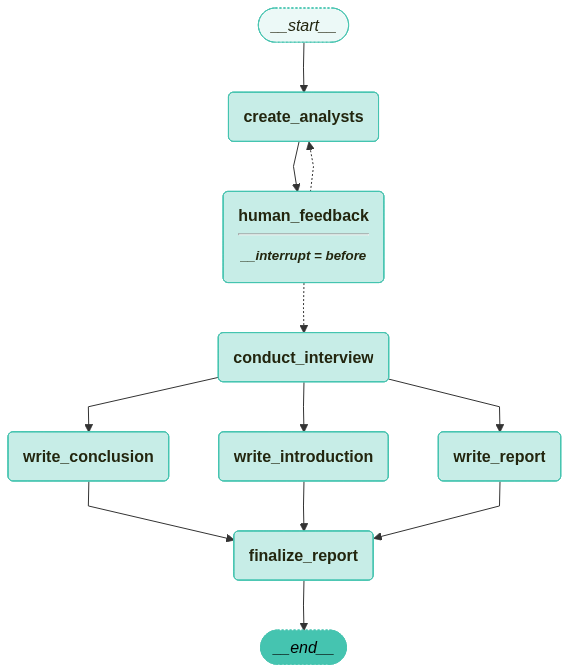

In [73]:
from langchain_teddynote.graphs import visualize_graph

visualize_graph(graph)

### 그래프 실행

In [ ]:
from langchain_teddynote.messages import random_uuid

config = RunnableConfig(
    recursion_limit=30,
    configurable={"thread_id": random_uuid()},
)

topic = "모듈형 RAG가 기존의 단순 RAG와 어떻게 다른지 설명하고, 이를 생산 단계에서 활용할 때의 이점을 제시하십시오."
inputs = {"topic": topic, "max_analysts": 3}
invoke_graph(
    graph,
    inputs,
    config,
    node_names=[
        "create_analysts",
        "generate_question",
        "generate_answer",
        "write_section",
        "write_report",
        "write_introduction",
        "write_conclusion",
        "finalize_report",
        "__interrupt__",
    ],
)



🔄 Node: create_analysts 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
affiliation='AI Research Institute' name='Dr. Mina Park' role='Comparative Technology Analyst' description='Dr. Park specializes in comparing emerging AI techniques, focusing on the architectural differences between modular RAG and traditional RAG. She evaluates how modular designs impact system flexibility, interpretability, and integration complexity.'
affiliation='Tech Solutions Inc.' name='Jae-Hyun Kim' role='Production Deployment Strategist' description='Mr. Kim is an expert in deploying AI systems at scale in production environments. He assesses the practical benefits of modular RAG for reliability, maintenance, scalability, and performance improvements over simple RAG implementations.'
affiliation='University of Data Science' name='Prof. Eun-Ji Lee' role='Innovation and Application Researcher' description='Prof. Lee investigates novel applications of AI architectures. She explores how modular RAG can e

In [75]:
invoke_graph(graph, Command(update={"human_feedback": None}), config)

Task __input__ with path () wrote to unknown channel human_feedback, ignoring it.



🔄 Node: human_feedback 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 

🔄 Node: generate_question in [conduct_interview] 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 

🔄 Node: generate_question in [conduct_interview] 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 

🔄 Node: search_arxiv in [conduct_interview] 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 

🔄 Node: search_arxiv in [conduct_interview] 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
<Document source="arxiv" url="http://arxiv.org/abs/2407.21059v1" date="2024-07-26" authors="Yunfan Gao, Yun Xiong, Meng Wang, Haofen Wang"/>
<Title>
Modular RAG: Transforming RAG Systems into LEGO-like Reconfigurable Frameworks
</Title>

<Summary>
Retrieval-augmented Generation (RAG) has markedly enhanced the capabilities
of Large Language Models (LLMs) in tackling knowledge-intensive tasks. The
increasing demands of application scenarios have driven the evolution of RAG,
leading to the integration of advanced retri

InvalidUpdateError: At key 'sections': Can receive only one value per step. Use an Annotated key to handle multiple values.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/INVALID_CONCURRENT_GRAPH_UPDATE

In [76]:
from IPython.display import Markdown

final_state = graph.get_state(config)
report = final_state.values.get("final_report")
display(Markdown(report))

InvalidUpdateError: At key 'sections': Can receive only one value per step. Use an Annotated key to handle multiple values.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/INVALID_CONCURRENT_GRAPH_UPDATE